# <font size =10 color='black'> LSS Hand On: session 2 </font> 

In [1]:
from __future__ import print_function

#####importing the necessary libraries
#To make the plots inline otherwise it will make seperate figure
%matplotlib inline 
#for high resolution plot outputs
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pylab as pl
import fitsio as F

# <font size =10 color='red'> Cosmology - The Next Decade </font> 
 
# <font size=6 color='blue'> International Center for Theoretical Science , Bangalore </font>

##  <font size=3 color='black'> Author: Shadab Alam (salam@roe.ac.uk) </font>




# <font size=6 color='blue'> Today's Goal: Simulated galaxy catalog and Real data </font>


# What is Dark Matter only N-body Cosmological Simulation?

Show the video on wiki and Leacy simulation video
https://en.wikipedia.org/wiki/File:N-body_Simulation.ogv


# Dark Matter Haloes?

# Galaxies (HOD)

# Simulated Galaxy Catalogue
datafile='/Users/shock/Documents/talks/ICTS2019/Tutorial/data/HOD_cat_model-bolshoi-ICTS-1.gcat'

# Correlation function
$$ \xi(r) = \frac{DD(r)}{ RR(r)} -1 $$

# Landy-Szalay Estimator
$$\xi(r) = \frac{DD(r) - 2*DR(r) + RR(r)}{RR(r)} $$

# Measure 3D clustering  in 2D space

<img src="../images/measure-2D-clustering.png" alt="drawing" width="1000"/>

$$\xi(r_\perp,r_\parallel) = \frac{DD((r_\perp,r_\parallel) - 2DR((r_\perp,r_\parallel) + RR((r_\perp,r_\parallel)}{RR((r_\perp,r_\parallel)} $$

# Measure 2D clustering in redshift space and make plots

There are several publicly available codes to measure correlation function. The goal here is not to understand how you will write such a code but rather what are the decision one need to make. Once you understand those decisions then you can download and use any of the publicly available code pretty easily.
We will be internally using this code written by me:
https://gitlab.com/shadaba/CorrelationFunction


We will be using following function to do our measurement, lets try to understand its signature first and use it once to measure the correlation function of galaxies in a simulated catalogue

our simulated catalogue of galaxies is in this file:
# datafile='../data/HOD_cat_model-bolshoi-ICTS-1.gcat'

In [15]:
def get_xi(datafile,rlim=[0,20,-20,20],nbins=[30,40],Lbox=250.0,
                  POS_min=[0,0,0],sampmode=1,njn=0,pbc=1,los=1,interactive=1,plots=0,rsd=0,
                  randfile='',filetype='txt',randfactor=2):
    
    ''' This measures the correlation function 
    sampmode= 0=rmu , 1=rpara-rperp, 2=rtheta, 
    3=log(rpar)-rperp (The range of r_perp in samplim should be entered in the log space), 
    4=log(r)-theta (The range of r in samplim should be entered in the log space)
    randfactor: number of times randoms compared to galaxies'''
    

    comm='../CorrelationFunction/Runme_Correlation.py'
    comm='%s -data %s'%(comm,datafile)
    
    if(randfile!=''):
        comm='%s -rand %s -randfactor %d'%(comm,randfile,randfactor)
        RRtype=''
    #elif(njn==0):
    #    comm='%s -rand norand -randfactor 2'%(comm)
    #    RRtype='norand'
    elif(np.int(np.sqrt(njn))!=np.sqrt(njn)):
        print('njn must be a perfect square but it is not %d'%njn)
        sys.exit()
    else:
        comm='%s -rand generate -randfactor %d'%(comm,randfactor)
        RRtype=''
        
    comm='%s -sampmode %d -samplim %f %f %f %f'%(comm,sampmode,rlim[0],rlim[1],rlim[2],rlim[3])
    comm='%s -nbins %d %d'%(comm,nbins[0],nbins[1])
    comm='%s -pbc %d -los %d -Lbox %f -outfile tmp/PairCount/tmp'%(comm,pbc,los,Lbox)
    comm='%s -RSD %d -njn %d -filetype %s -nproc 4'%(comm,rsd,njn,filetype)
    

    
    
    print(comm)
    #execute the command
    !python $comm
    
    #convert pair count to xi
    if(False):
        pxi_comm='../CorrelationFunction/PairCountTOxi.py'
        pxi_comm='%s -sampmode %d -njn %d -Lbox %f'%(pxi_comm,sampmode,njn,Lbox)
        pxi_comm='%s -pcroot tmp/PairCount/tmp'%(pxi_comm)
        pxi_comm='%s  -xi2droot tmp/XI2D/tmp'%(pxi_comm)
        pxi_comm='%s -xi02root tmp/WP/tmp'%(pxi_comm)
        if(RRtype!=''):
            pxi_comm='%s -RRtype %s'%(pxi_comm,RRtype)

        #pxi_comm='%s '%(pxi_comm)   
        !python $pxi_comm
    
    
    #load result in dictionary
    xi_dic={}
    if(sampmode in [1,3]):
        xi_dic['rpar_ed']=np.linspace(rlim[2],rlim[3],nbins[1]+1)
        xi_dic['rper_ed']=np.linspace(rlim[0],rlim[1],nbins[0]+1)
        if(sampmode==3):
            xi_dic['rper_ed']=np.power(10,xi_dic['rper_ed'])
            
        xi_dic['rpar']=0.5*(xi_dic['rpar_ed'][1:]+xi_dic['rpar_ed'][:-1])
        xi_dic['rper']=0.5*(xi_dic['rper_ed'][1:]+xi_dic['rper_ed'][:-1])
        xi2d=np.loadtxt('tmp/XI2D/tmp-rp-pi-NJN-%d.txt'%njn)
        if(njn!=0):
            xi2d=xi2d[:,0]
    
        xi2d=np.transpose(xi2d.reshape(nbins[0],nbins[1]))
        xi_dic['xi2d']=np.column_stack([xi2d[:,::-1],xi2d])
        xi_dic['rper']=np.append(-xi_dic['rper'][::-1],xi_dic['rper'])
        
        #load wp
        xi_dic['wp']=np.loadtxt('tmp/WP/tmp-wp-rp-pi-NJN-%d.txt'%njn)
        
    if(sampmode ==0):
        xi_dic['r3d_ed']=np.linspace(rlim[2],rlim[3],nbins[1]+1)
        xi_dic['mu_ed']=np.linspace(rlim[0],rlim[1],nbins[0]+1)
        
        xi_dic['r3d']=0.5*(xi_dic['r3d_ed'][1:]+xi_dic['r3d_ed'][:-1])
        xi_dic['mu']=0.5*(xi_dic['mu_ed'][1:]+xi_dic['mu_ed'][:-1])
        xi2d=np.loadtxt('tmp/XI2D/tmp-rmu-NJN-%d.txt'%njn)
        if(njn!=0):
            xi2d=xi2d[:,0]
            
        xi_dic['xi2d']=np.transpose(xi2d.reshape(nbins[0],nbins[1]))
        
        #load xi0/xi2
        xi_dic['xi0']=np.loadtxt('tmp/XI02/tmp-xi0-rmu-NJN-%d.txt'%njn)
        xi_dic['xi2']=np.loadtxt('tmp/XI02/tmp-xi2-rmu-NJN-%d.txt'%njn)
        
    return xi_dic

def draw_circle(radius=1.0,color='r'):
    xx=np.linspace(0,radius,30)
    yy=np.sqrt(np.power(radius,2)-np.power(xx,2))
    
    pl.plot(xx,yy,'-',color=color)
    pl.plot(-xx,yy,'-',color=color)
    pl.plot(-xx,-yy,'-',color=color)
    pl.plot(xx,-yy,'-',color=color)
    
    return 0

# Explain following things:
1) get_xi function signature with rlims, nbins, Lbox
     $$rlims=[r_{\perp}^{min}, r_{\perp}^{max},r_{\parallel}^{min}, r_{\parallel}^{max}]$$
     $$nbins=[\text{number of bins in the first axis}, \text{number of bins in the second axis}] $$
     $$L_{box}= 250$$

2) python dictionary including xi2d, rper and rpar

3) pl.imshow


# <font size=5, color='blue'> Work 1 (10 minutes): Measure the clustering of simulation </font>
Now write the code to measure the 2D correlation function of simulated galaxy catalogue using the function
<font size=3, color='green'> get_xi</font>

and plot the measured clustering. You should measure the clustering for rper 0-30 (Mpc/h)and rpar -30 to 30 (Mpc/h).

Also draw a circle of certain radius to compare the contours with circle.

# use the cells below to write and execute the code you can create new cells by clicking on the + sign on the top panel below File

In [13]:
#solutione to work 1 part 1
datafile='../data/HOD_cat_model-bolshoi-ICTS-1.gcat'
xi_dic=get_xi(datafile,rlim=[0,30,-30,30],nbins=[30,60],Lbox=250.0)

../CorrelationFunction/Runme_Correlation.py -data ../data/HOD_cat_model-bolshoi-ICTS-1.gcat -rand generate -randfactor 2 -sampmode 1 -samplim 0.000000 30.000000 -30.000000 30.000000 -nbins 30 60 -pbc 1 -los 1 -Lbox 250.000000 -outfile tmp/PairCount/tmp -RSD 0 -njn 0 -filetype txt -nproc 4


<ipython-input-3-5adea6acf7f6>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif(np.int(np.sqrt(njn))!=np.sqrt(njn)):


outfile : tmp/PairCount/tmp
random file not given, Generating internal random
     39287 galaxies from ../data/HOD_cat_model-bolshoi-ICTS-1.gcat
     78574 randoms from generate

Time:0 sec
../CorrelationFunction/Runme_Correlation.py:839: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print("\nPrepared data and random:%d sec"%np.int(time.time() - t0))

Prepared data and random:0 sec

Workind on DD (. every 100k points):

Finished DD in 12 sec with 4 process and 39287 39287 particles, max scale    30.0000

Workind on DR (. every 100k points):

Fini

<ipython-input-14-71109a12d2b1>:6: RuntimeWarning: invalid value encountered in log10
  pl.pcolor(xi_dic['rper']-drper,xi_dic['rpar']-drpar,np.log10(xi_dic['xi2d']))
<ipython-input-14-71109a12d2b1>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolor(xi_dic['rper']-drper,xi_dic['rpar']-drpar,np.log10(xi_dic['xi2d']))
<ipython-input-14-71109a12d2b1>:12: RuntimeWarning: invalid value encountered in log10
  pl.contour(xi_dic['rper'],xi_dic['rpar'],np.log10(xi_dic['xi2d']),colors='k')


0

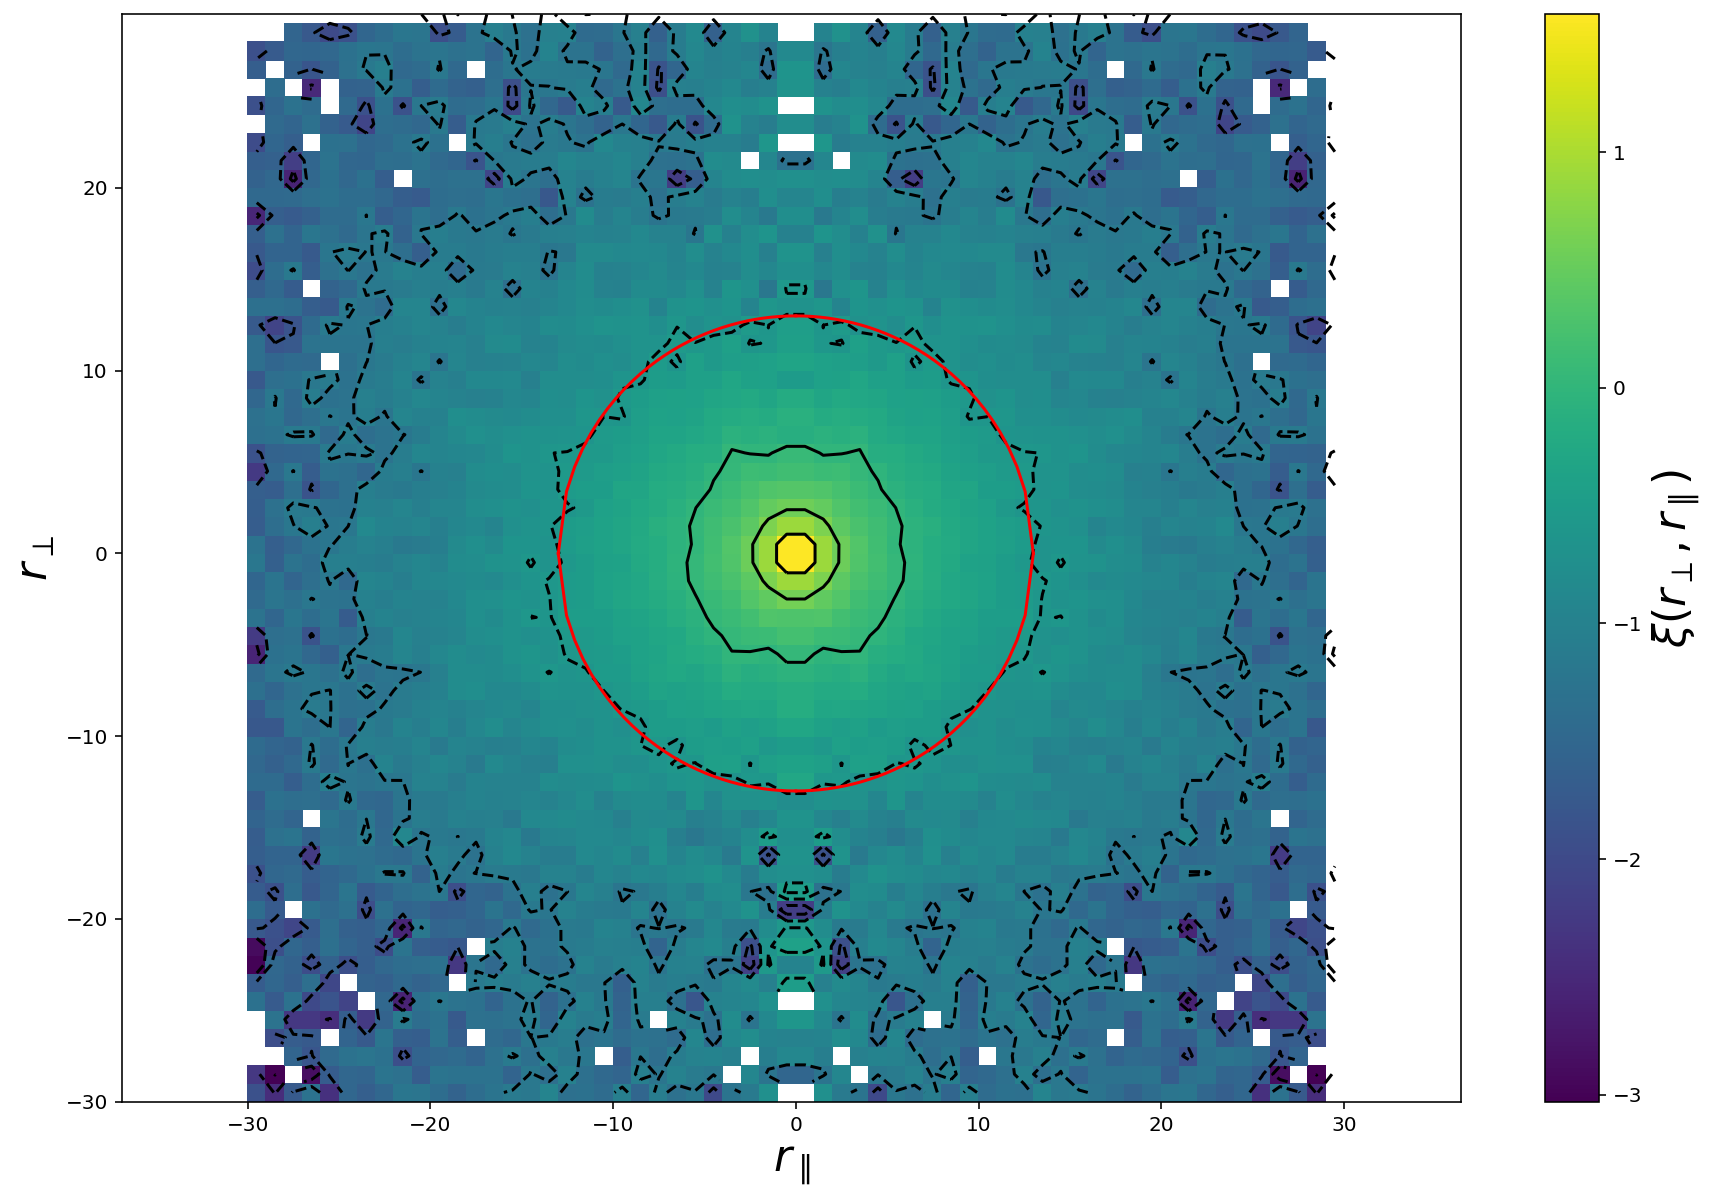

In [14]:
#solutione to work 1 part 2
drper=0.5*np.mean(xi_dic['rper'][1:]-xi_dic['rper'][:-1])
drpar=0.5*np.mean(xi_dic['rpar'][1:]-xi_dic['rpar'][:-1])

pl.figure(figsize=(15,10))
pl.pcolor(xi_dic['rper']-drper,xi_dic['rpar']-drpar,np.log10(xi_dic['xi2d']))

#add color bar
pl.colorbar().set_label(label=r'$\xi(r_\perp,r_\parallel)$',size=22,weight='bold')

#make the contour plot
pl.contour(xi_dic['rper'],xi_dic['rpar'],np.log10(xi_dic['xi2d']),colors='k')

pl.xlabel(r'$r_\parallel$',fontsize=22)
pl.ylabel(r'$r_\perp$',fontsize=22)
pl.xlim([-30,30])
pl.ylim([-30,30])

pl.axis('equal')

draw_circle(radius=13.0,color='r') 

# How will the clustering look like with redshift space distortion?


# <font size=5, color='blue'> Work 2 (10 minutes): Redshift Space correlation function </font>
move galaxies to their redshift space position by setting rsd=1 in get_xi and measure the clustering signal again.
Make a plot to compare this with your previous plot. Also draw a circle of radius 10 on top of the correlation function to see if this is symmetric.

In [11]:
#solution to work 2 part 1
datafile='../data/HOD_cat_model-bolshoi-ICTS-1.gcat'
xi_dic=get_xi(datafile,rlim=[0,30,-30,30],nbins=[30,60],Lbox=250.0,rsd=1)

../CorrelationFunction/Runme_Correlation.py -data ../data/HOD_cat_model-bolshoi-ICTS-1.gcat -rand generate -randfactor 2 -sampmode 1 -samplim 0.000000 30.000000 -30.000000 30.000000 -nbins 30 60 -pbc 1 -los 1 -Lbox 250.000000 -outfile tmp/PairCount/tmp -RSD 1 -njn 0 -filetype txt -nproc 4


<ipython-input-3-5adea6acf7f6>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif(np.int(np.sqrt(njn))!=np.sqrt(njn)):


outfile : tmp/PairCount/tmp
random file not given, Generating internal random
     39287 galaxies from ../data/HOD_cat_model-bolshoi-ICTS-1.gcat
     78574 randoms from generate

Time:0 sec
../CorrelationFunction/Runme_Correlation.py:839: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print("\nPrepared data and random:%d sec"%np.int(time.time() - t0))

Prepared data and random:0 sec

Workind on DD (. every 100k points):

Finished DD in 12 sec with 4 process and 39287 39287 particles, max scale    30.0000

Workind on DR (. every 100k points):

Fini

<ipython-input-12-ed7055248de7>:6: RuntimeWarning: invalid value encountered in log10
  pl.pcolor(xi_dic['rper']-drper,xi_dic['rpar']-drpar,np.log10(xi_dic['xi2d']),vmin=-2,vmax=2)
<ipython-input-12-ed7055248de7>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolor(xi_dic['rper']-drper,xi_dic['rpar']-drpar,np.log10(xi_dic['xi2d']),vmin=-2,vmax=2)
<ipython-input-12-ed7055248de7>:12: RuntimeWarning: invalid value encountered in log10
  pl.contour(xi_dic['rper'],xi_dic['rpar'],np.log10(xi_dic['xi2d']),colors='k')


0

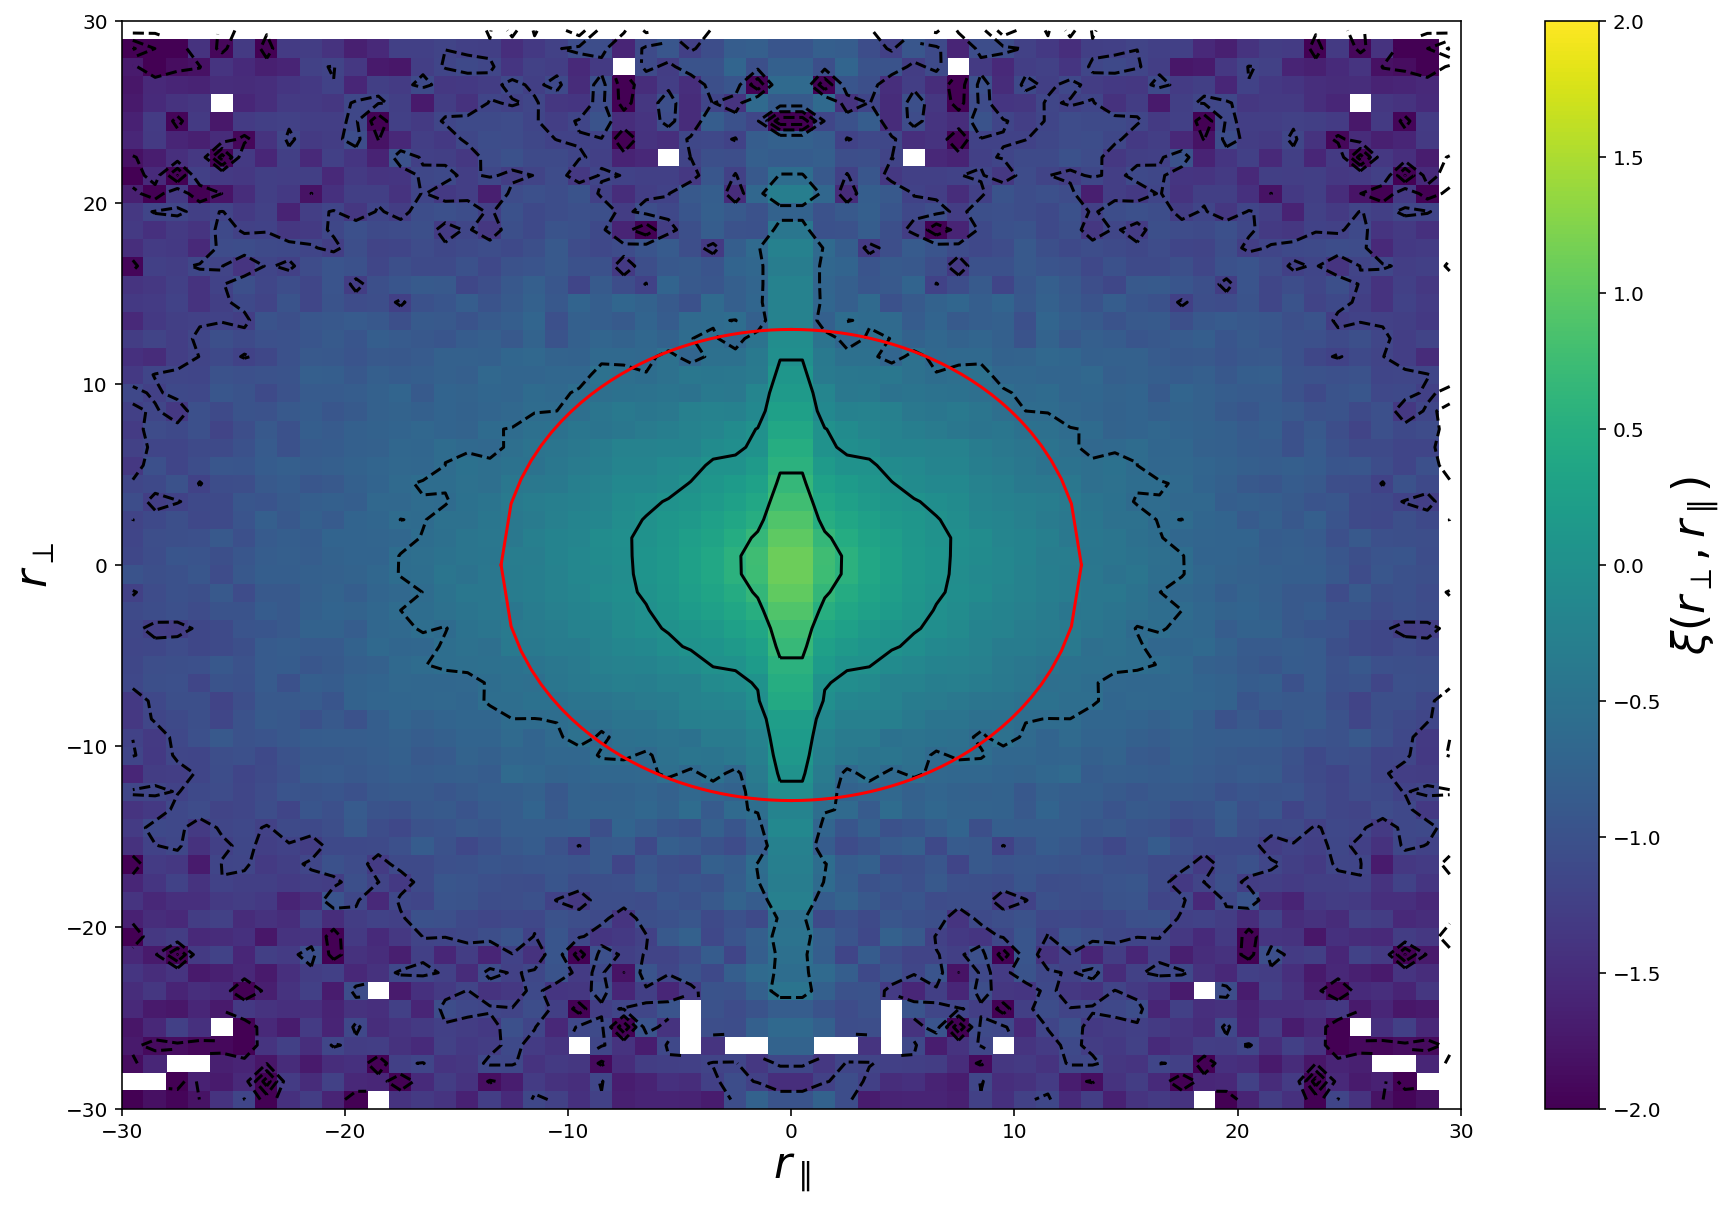

In [12]:
#solutione to work 2 part 2
drper=0.5*np.mean(xi_dic['rper'][1:]-xi_dic['rper'][:-1])
drpar=0.5*np.mean(xi_dic['rpar'][1:]-xi_dic['rpar'][:-1])

pl.figure(figsize=(15,10))
pl.pcolor(xi_dic['rper']-drper,xi_dic['rpar']-drpar,np.log10(xi_dic['xi2d']),vmin=-2,vmax=2)

#add color bar
pl.colorbar().set_label(label=r'$\xi(r_\perp,r_\parallel)$',size=22,weight='bold')

#make the contour plot
pl.contour(xi_dic['rper'],xi_dic['rpar'],np.log10(xi_dic['xi2d']),colors='k')

pl.xlabel(r'$r_\parallel$',fontsize=22)
pl.ylabel(r'$r_\perp$',fontsize=22)
pl.xlim([-30,30])
pl.ylim([-30,30])

draw_circle(radius=13.0,color='r')   

# Multipole expansion

<img src="../images/multipole-expansion.png" alt="drawing" width="1000"/>

# Explain sampmode in get_xi and rlims. Also explain xi0 and xi2 in dictionary

# <font size=5, color='blue'> Work 3 (10 minutes): Compute the multipole moments using get_xi in real and redshift space make a plot with pair seperation (r) on x-axis and either r^2 monopole or r^2 Quadruple on the y-axis</font>




In [16]:
#solution p
datafile='../data/HOD_cat_model-bolshoi-ICTS-1.gcat'
xi_dic_wrsd=get_xi(datafile,rlim=[0,30,0,1],nbins=[30,100],Lbox=250.0,rsd=1,sampmode=0,randfactor=2)
xi_dic_norsd=get_xi(datafile,rlim=[0,30,0,1],nbins=[30,100],Lbox=250.0,rsd=0,sampmode=0,randfactor=2)

../CorrelationFunction/Runme_Correlation.py -data ../data/HOD_cat_model-bolshoi-ICTS-1.gcat -rand generate -randfactor 2 -sampmode 0 -samplim 0.000000 30.000000 0.000000 1.000000 -nbins 30 100 -pbc 1 -los 1 -Lbox 250.000000 -outfile tmp/PairCount/tmp -RSD 1 -njn 0 -filetype txt -nproc 4


<ipython-input-15-74f2116fd096>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif(np.int(np.sqrt(njn))!=np.sqrt(njn)):


outfile : tmp/PairCount/tmp
random file not given, Generating internal random
     39287 galaxies from ../data/HOD_cat_model-bolshoi-ICTS-1.gcat
     78574 randoms from generate

Time:0 sec
../CorrelationFunction/Runme_Correlation.py:839: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print("\nPrepared data and random:%d sec"%np.int(time.time() - t0))

Prepared data and random:0 sec

Workind on DD (. every 100k points):

Finished DD in 5 sec with 4 process and 39287 39287 particles, max scale    30.0000

Workind on DR (. every 100k points):

Finis

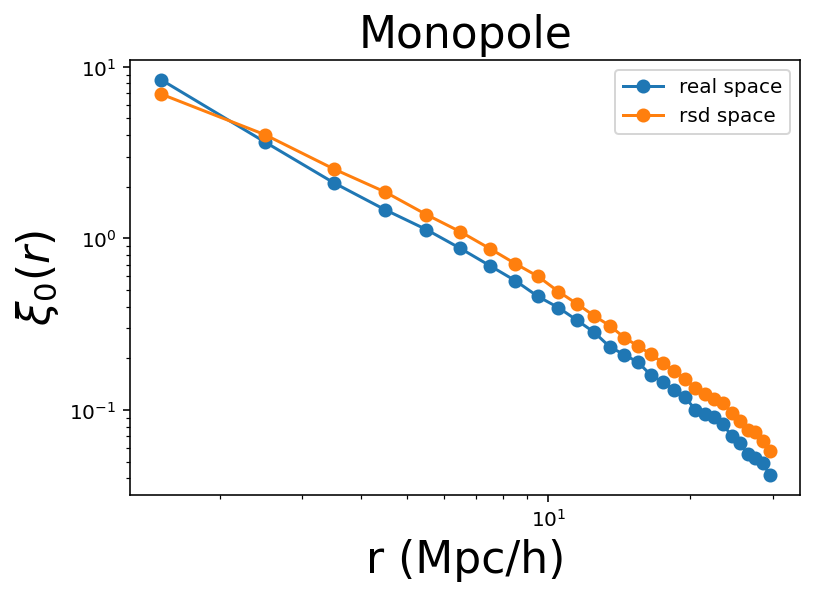

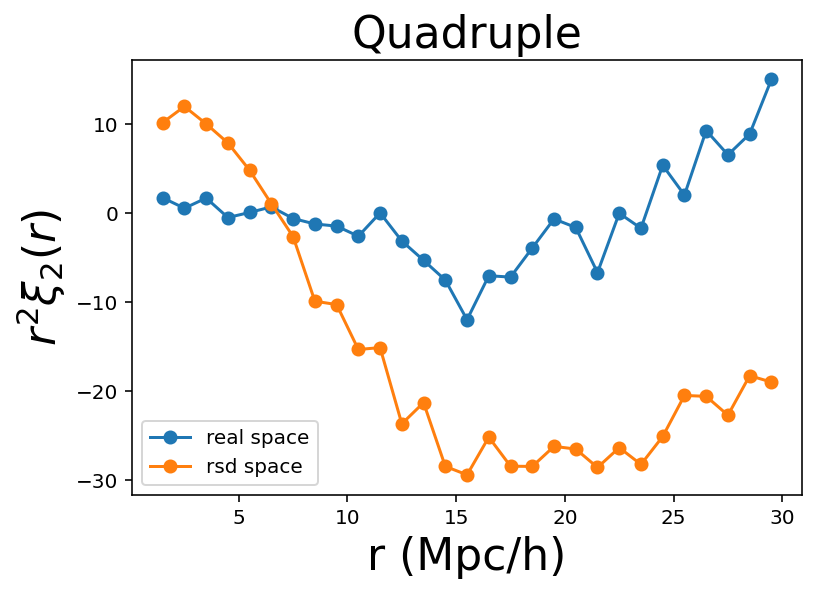

In [17]:
tlab=['real space','rsd space']
for ii,xi_dic in enumerate([xi_dic_norsd,xi_dic_wrsd]):
    pl.figure(1)
    pl.plot(xi_dic['xi0'][:,0],np.power(xi_dic['xi0'][:,0],0)*xi_dic['xi0'][:,1],'o-',label=tlab[ii])
    pl.legend()
    pl.xscale('log')
    pl.yscale('log')
    pl.title('Monopole',fontsize=22)
    pl.xlabel('r (Mpc/h)',fontsize=22)
    pl.ylabel(r'$\xi_0(r)$',fontsize=22)
    
    pl.figure(2)
    pl.plot(xi_dic['xi2'][:,0],np.power(xi_dic['xi2'][:,0],2)*xi_dic['xi2'][:,1],'o-',label=tlab[ii])
    pl.legend()
    pl.title('Quadruple',fontsize=22)
    pl.xlabel('r (Mpc/h)',fontsize=22)
    pl.ylabel(r'$r^2 \xi_2(r)$',fontsize=22)

# Estimation of error:
There are several methods to quanitfy the error on clustering signal. Typically the simplest and most accurate but computationally expensive methods uses N-body simulations. The computationally least expensive but complex and approximate method use perturbation theory and most popular method uses approximate mocks which are fast simulation using perturbation theory methods.

We can also estimate the error from data. Two such methods widely used are know as "Jakknife" and "Bootstrap". 
Both of these methods can be shown to work exactly right with known biases if the assumptions are satisfied.
But in comoslogical analysis those assumptions are not entirely satisfied and hence these methods can over or under estimate error depending on the situation.

# Jackknife errors

<img src="../images/jackknife-resampling.png" alt="drawing" width="600"/>

$$Var(s_i)= \frac{(N_{jn}-1)}{N_{jn}}  \sum_{jn=0}^{jn<njn} (s_{jn,i}- \bar{s_i}) ^2$$



# explain pl.errorbar(x,y,yerr) and njn in get_xi including modified output xi0,xi2

# <font size=5, color='blue'> Work 4 (10 minutes): Compute the multipole moments using get_xi in real and redshift space make a plot with pair seperation (r) on x-axis and either r^2 monopole or r^2 Quadruple on the y-axis</font>





In [18]:
datafile='../data/HOD_cat_model-bolshoi-ICTS-1.gcat'
xi_dic_wrsd=get_xi(datafile,rlim=[0,30,0,1],nbins=[30,100],Lbox=250.0,rsd=1,sampmode=0,njn=25)
xi_dic_norsd=get_xi(datafile,rlim=[0,30,0,1],nbins=[30,100],Lbox=250.0,rsd=0,sampmode=0,njn=25)

../CorrelationFunction/Runme_Correlation.py -data ../data/HOD_cat_model-bolshoi-ICTS-1.gcat -rand generate -randfactor 2 -sampmode 0 -samplim 0.000000 30.000000 0.000000 1.000000 -nbins 30 100 -pbc 1 -los 1 -Lbox 250.000000 -outfile tmp/PairCount/tmp -RSD 1 -njn 25 -filetype txt -nproc 4


<ipython-input-15-74f2116fd096>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif(np.int(np.sqrt(njn))!=np.sqrt(njn)):


outfile : tmp/PairCount/tmp
random file not given, Generating internal random
Using 2d Jacknife: 5 5
     39287 galaxies from ../data/HOD_cat_model-bolshoi-ICTS-1.gcat
     78574 randoms from generate

Time:0 sec
../CorrelationFunction/Runme_Correlation.py:839: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print("\nPrepared data and random:%d sec"%np.int(time.time() - t0))

Prepared data and random:0 sec

Workind on DD (. every 100k points):

Finished DD in 6 sec with 4 process and 39287 39287 particles, max scale    30.0000

Workind on DR (. eve

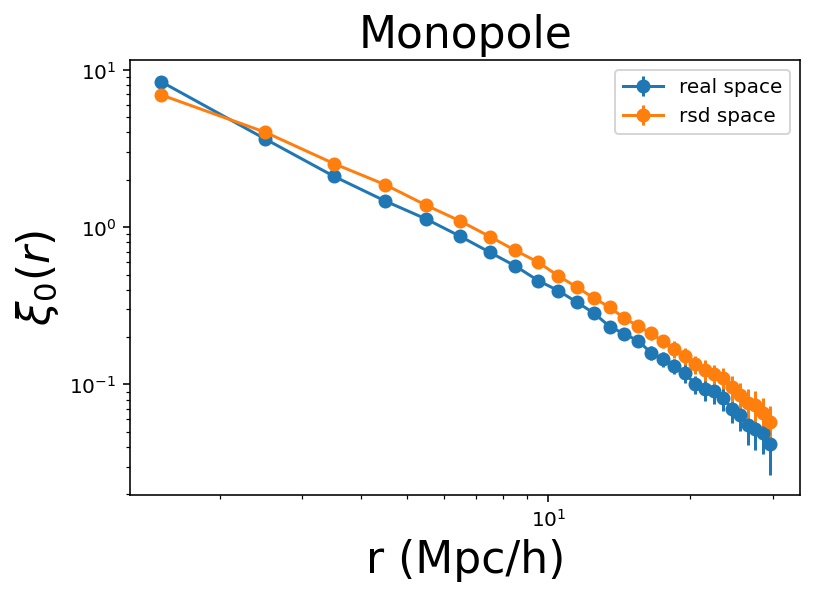

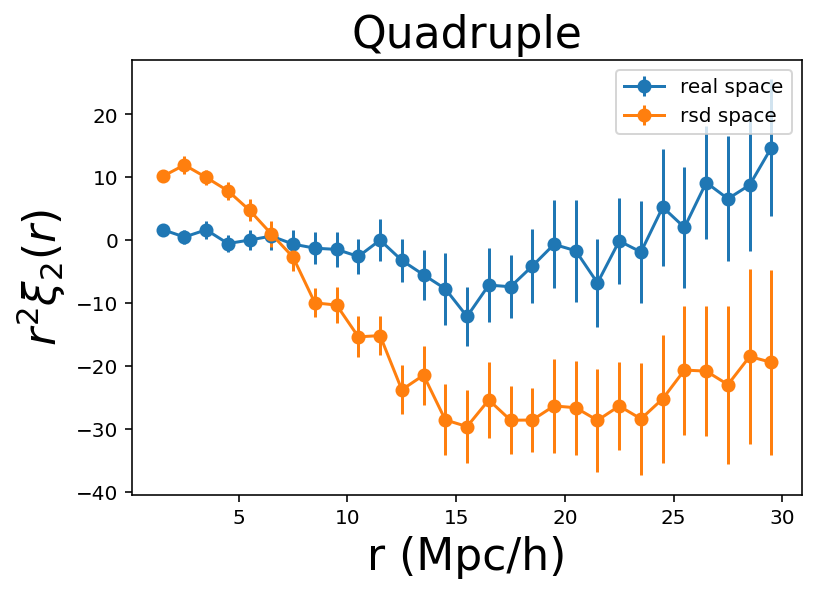

In [19]:
tlab=['real space','rsd space']
for ii,xi_dic in enumerate([xi_dic_norsd,xi_dic_wrsd]):
    pl.figure(1)
    pl.errorbar(xi_dic['xi0'][:,0],np.power(xi_dic['xi0'][:,0],0)*xi_dic['xi0'][:,1],
               yerr=np.power(xi_dic['xi0'][:,0],0)*xi_dic['xi0'][:,2],marker='o',label=tlab[ii])
    pl.legend()
    pl.xscale('log')
    pl.yscale('log')
    pl.title('Monopole',fontsize=22)
    pl.xlabel('r (Mpc/h)',fontsize=22)
    pl.ylabel(r'$\xi_0(r)$',fontsize=22)
    
    pl.figure(2)
    
    pl.errorbar(xi_dic['xi2'][:,0],np.power(xi_dic['xi2'][:,0],2)*xi_dic['xi2'][:,1],
               yerr=np.power(xi_dic['xi2'][:,0],2)*xi_dic['xi2'][:,2],marker='o',label=tlab[ii])
    
    pl.legend()
    pl.title('Quadruple',fontsize=22)
    pl.xlabel('r (Mpc/h)',fontsize=22)
    pl.ylabel(r'$r^2 \xi_2(r)$',fontsize=22)

# Constructing a Jackknife covariance matrix


# Variance:
$$Var(s_i)= \frac{(N_{jn}-1)}{N_{jn}}  \sum_{jn=0}^{jn<njn} (s_{jn,i}- \bar{s_i}) ^2$$

# Covariance matrix
$$C_{i,j}= \frac{(N_{jn}-1)}{N_{jn}} \sum_{jn=0}^{jn<njn} (s_{jn,i}- \bar{s_i}) \sum_{jn=0}^{jn<njn} (s_{jn,j}- \bar{s_j})$$

# Correlation matrix
$$Corr_{i,j}=\frac{C_{i,j}}{\sqrt{C_{i,i}C_{j,j}}}$$

# Example covariance matrix of monopole

Text(0.5, 1.0, 'correlation matrix of monopole')

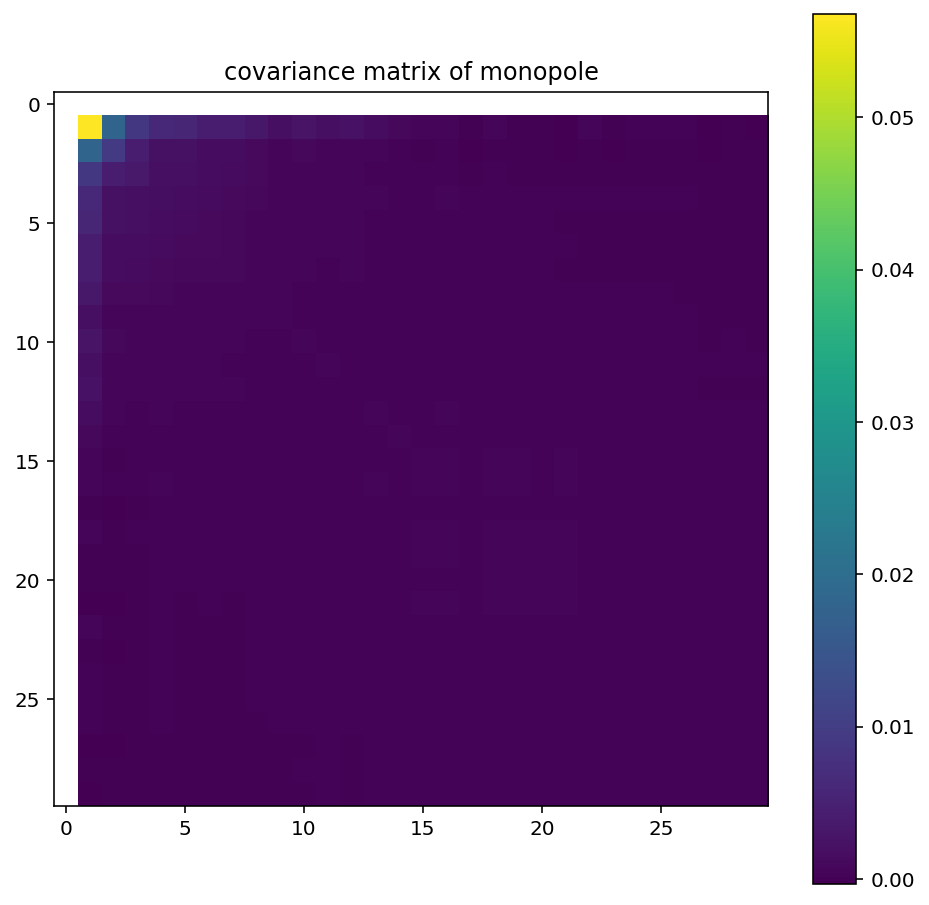

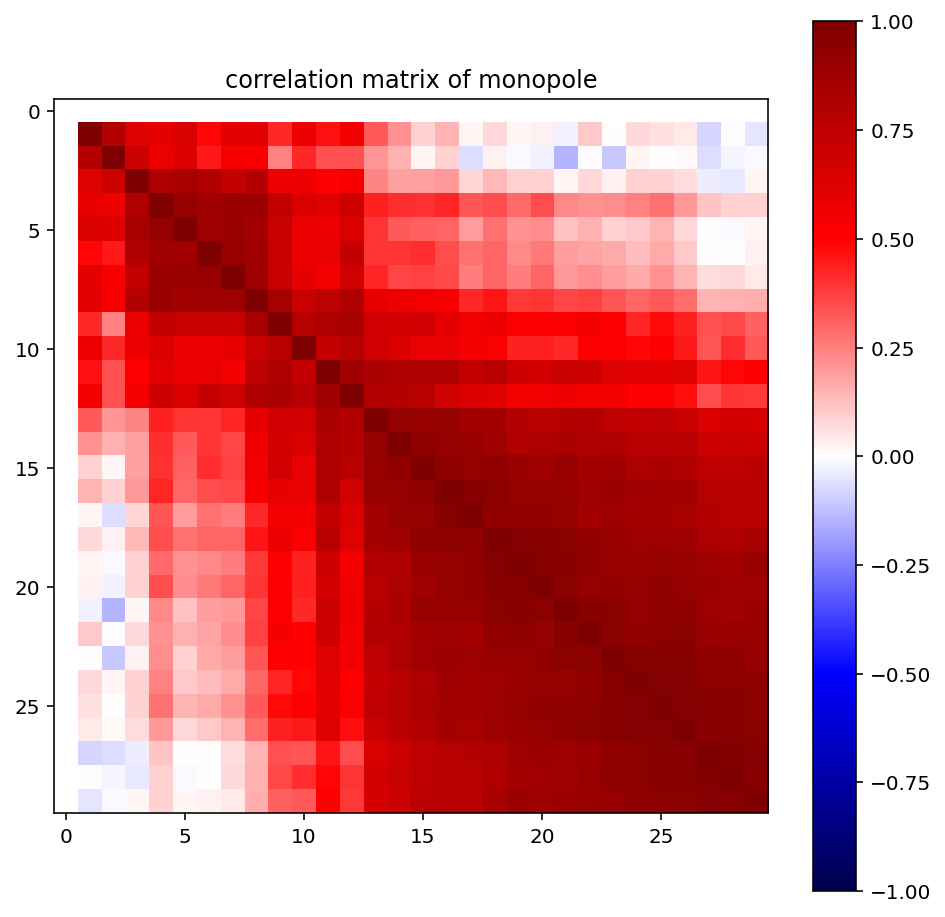

In [21]:
#covariance of the monopole
njn=xi_dic_wrsd['xi0'].shape[1]-4

covxi0=(njn-1)*np.cov(xi_dic_wrsd['xi0'][:,4:])

pl.figure(figsize=(8,8))
pl.imshow(covxi0)
pl.colorbar()
pl.title('covariance matrix of monopole')

corrxi0=np.copy(covxi0)
for ii in range(0,covxi0.shape[0]):
    for jj in range(0,covxi0.shape[1]):
        corrxi0[ii,jj]=covxi0[ii,jj]/(np.sqrt(covxi0[ii,ii])*np.sqrt(covxi0[jj,jj]))

pl.figure(figsize=(8,8))
pl.imshow(corrxi0,vmin=-1,vmax=1,cmap='seismic')
pl.colorbar()       
pl.title('correlation matrix of monopole')


# <font size=5, color='blue'> Work 5 (5 minutes): Compute the covariance and correlation matrix of Quadruple moment of the correlation function and make plots</font>




Text(0.5, 1.0, 'correlation matrix of Quadrupole')

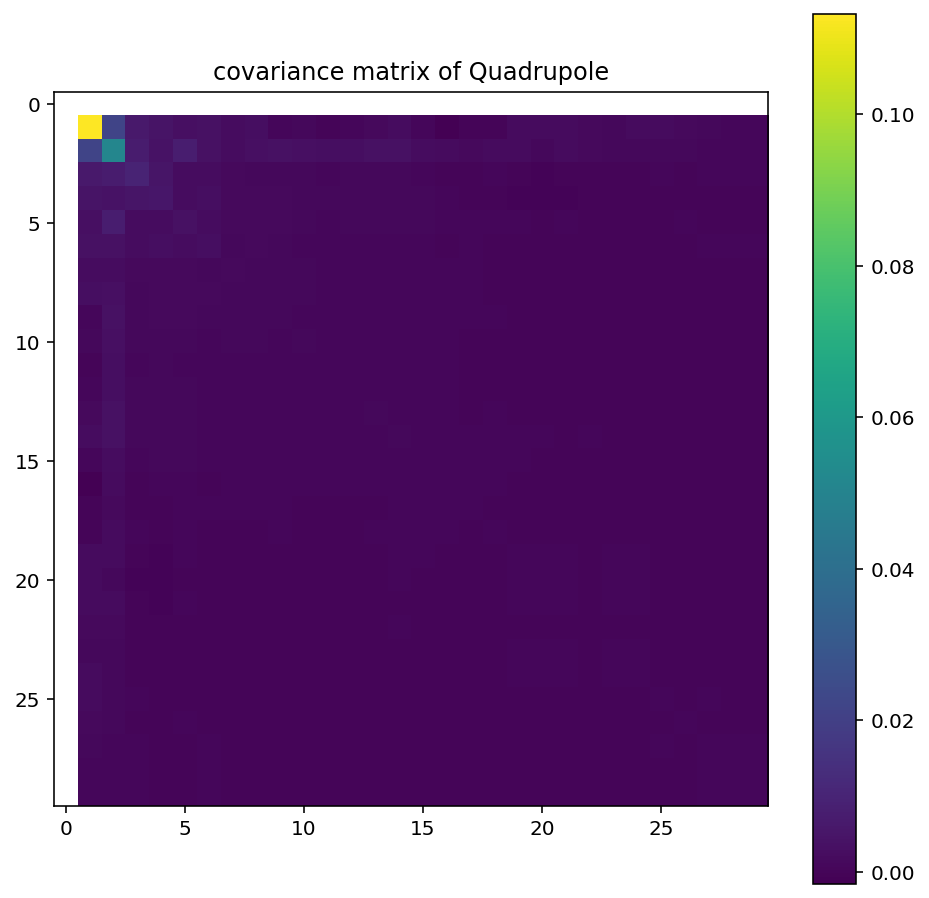

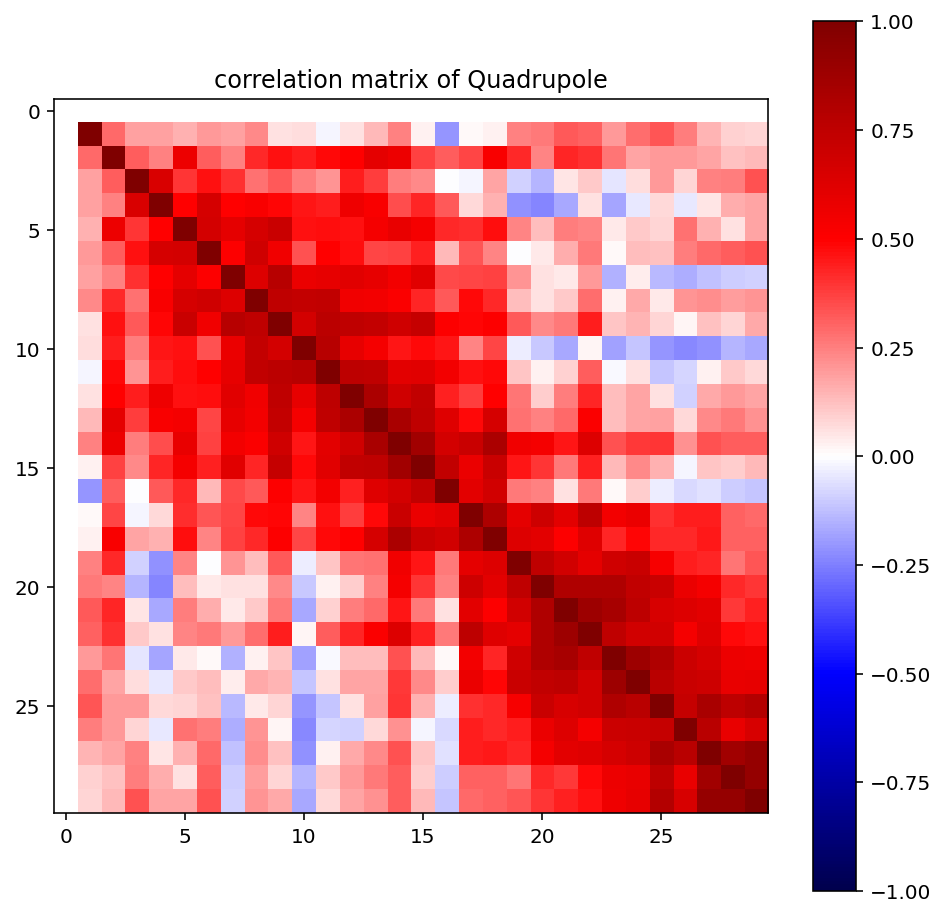

In [22]:
#covariance of the Quadrupole
njn=xi_dic_wrsd['xi2'].shape[1]-4

covxi2=(njn-1)*np.cov(xi_dic_wrsd['xi2'][:,4:])

pl.figure(figsize=(8,8))
pl.imshow(covxi2)
pl.colorbar()
pl.title('covariance matrix of Quadrupole')

corrxi2=np.copy(covxi2)
for ii in range(0,covxi2.shape[0]):
    for jj in range(0,covxi2.shape[1]):
        corrxi2[ii,jj]=covxi2[ii,jj]/(np.sqrt(covxi2[ii,ii])*np.sqrt(covxi2[jj,jj]))

pl.figure(figsize=(8,8))
pl.imshow(corrxi2,vmin=-1,vmax=1,cmap='seismic')
pl.colorbar()       
pl.title('correlation matrix of Quadrupole')

# Combined and cross covariance of $\xi_0$ and $\xi_2$


# <font size=5, color='blue'> Work 6 (10 minutes): Compute the combined covariance and correlation matrix of $\xi_0$ and $\xi_2$ and make plots</font>

# Hint: use np.row_stack function to make combined array

/usr/local/anaconda3/envs/nbodykit/lib/python3.8/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


Text(0.5, 1.0, 'correlation matrix of combined')

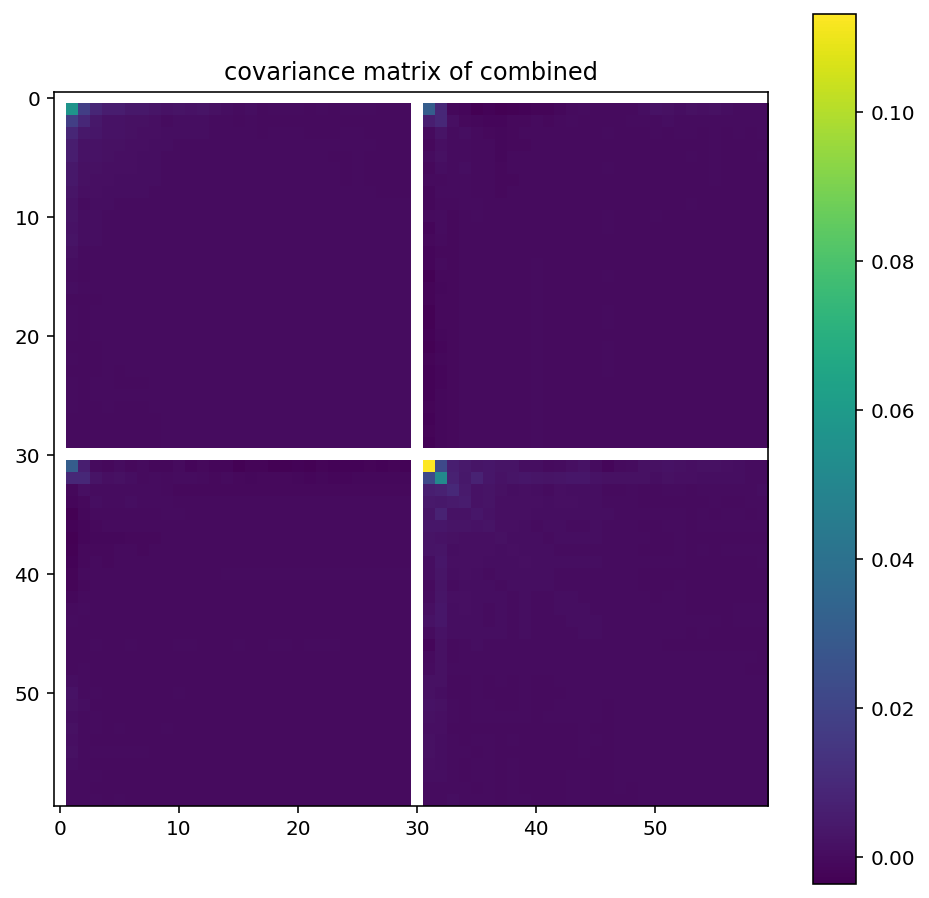

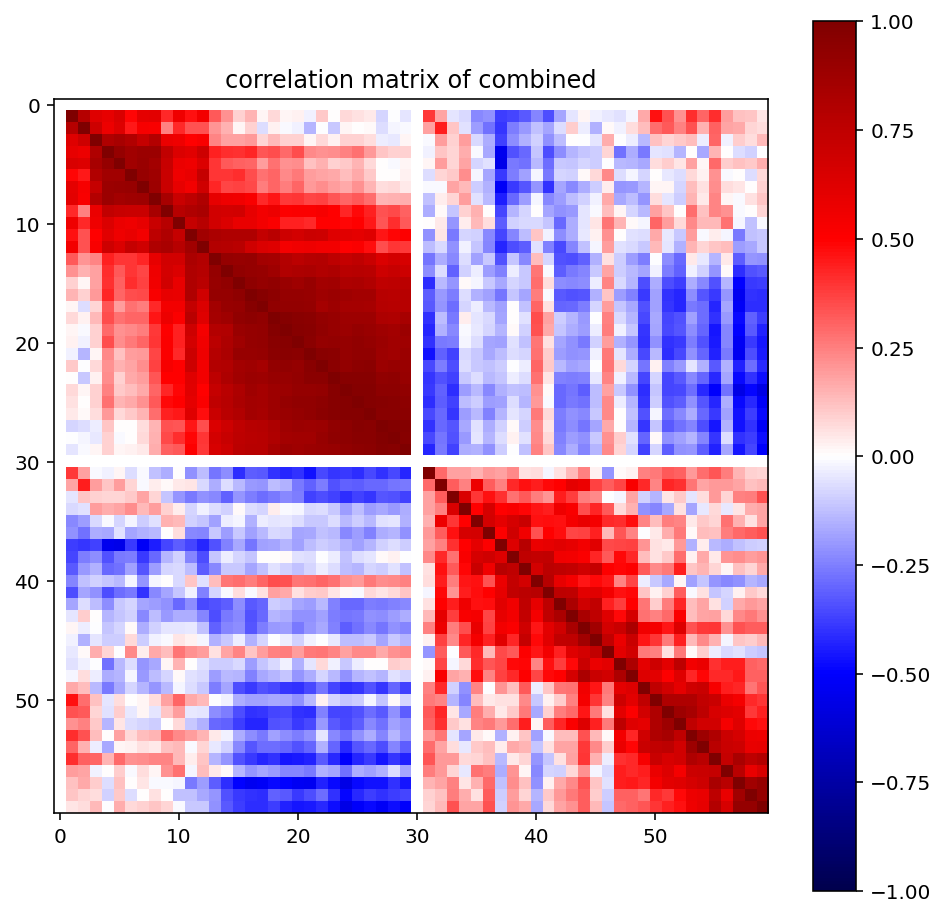

In [20]:
#Combined covariance matrix
njn=xi_dic_wrsd['xi2'].shape[1]-4

xi02=np.row_stack([xi_dic_wrsd['xi0'][:,4:],xi_dic_wrsd['xi2'][:,4:]])
covxi2=(njn-1)*np.cov(xi02)

pl.figure(figsize=(8,8))
pl.imshow(covxi2)
pl.colorbar()
pl.title('covariance matrix of combined')

corrxi2=np.copy(covxi2)
for ii in range(0,covxi2.shape[0]):
    for jj in range(0,covxi2.shape[1]):
        corrxi2[ii,jj]=covxi2[ii,jj]/(np.sqrt(covxi2[ii,ii])*np.sqrt(covxi2[jj,jj]))

pl.figure(figsize=(8,8))
pl.imshow(corrxi2,vmin=-1,vmax=1,cmap='seismic')
pl.colorbar()       
pl.title('correlation matrix of combined')

# Look at real data from Sloan Digital Sky Survey (SDSS)

#  <font size=5, color='green'> datafile= '../data/LOWZ-all-galaxy.txt' </font>
#  <font size=5, color='green'> randomfile= '../data/LOWZ-all-random.txt' </font>


# <font size=5, color='blue'> Exploration: (5 minutes) </font>

The file has three columns RA,DEC and redshift.
load the file using "np.loadtxt" which will give you a numpy array and explore the data by making plots and distribution of data.

Text(0.5, 1.0, 'histogram of redshift')

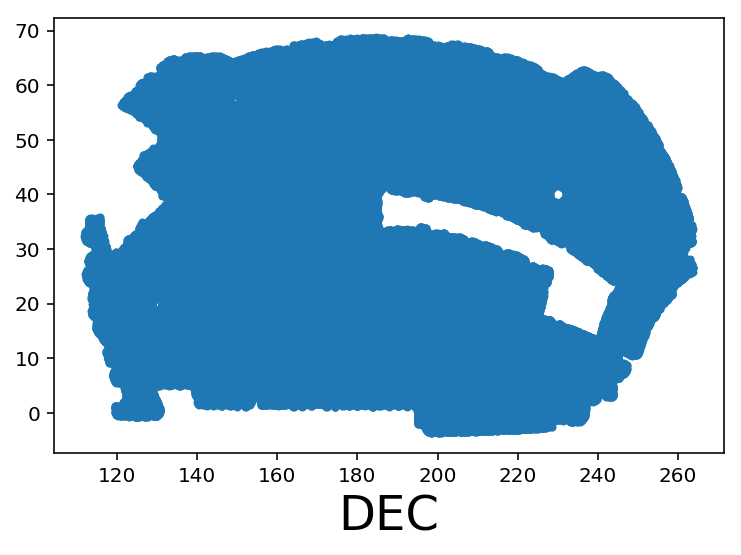

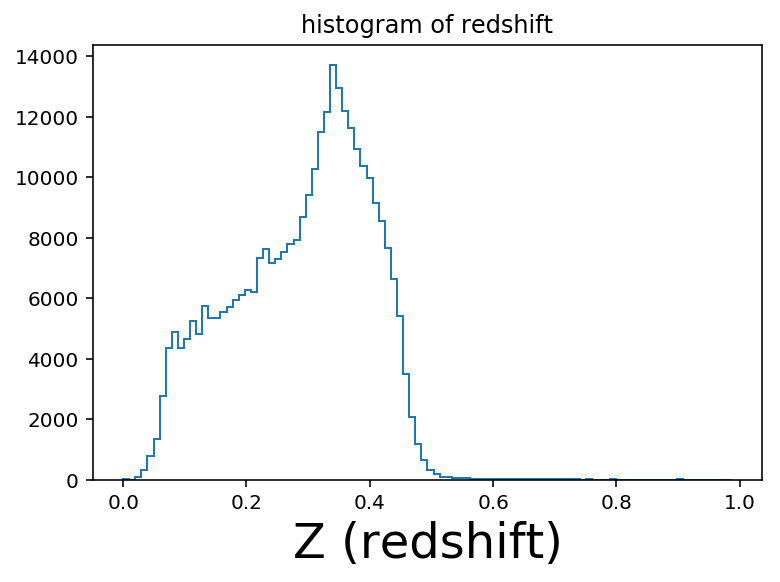

In [14]:
import numpy as np
#to load the data
datafile= '../data/LOWZ-all-galaxy.txt'
data=np.loadtxt(datafile)


pl.figure(1)
pl.plot(data[:,0],data[:,1],'.')
pl.xlabel('RA',fontsize=24)
pl.xlabel('DEC',fontsize=24)


pl.figure(3)
pl.hist(data[:,2],bins=100,histtype='step')
pl.xlabel('Z (redshift)',fontsize=24)
pl.title('histogram of redshift')

# Explain following inputs of get_xi

randfile='',sampmode=1, pbc=0, njn=0, los=0, rsd=0, filetype='polartxt'

# <font size=5, color='blue'> Work 7 (10 minutes): Now compute the clustering of data with rper=0,20 and rpar=-20,20 and make a 2d plot with axis as rper and rpar and the color axis as logarithm of the correlation function also plot contours </font>

# Hint: use pl.imshow and pl.contour for plotting

In [15]:
datafile='../data/LOWZ-all-galaxy.txt'
randfile='../data/LOWZ-all-random.txt'
xi_dic=get_xi(datafile,randfile=randfile,rlim=[0,20,-20,20],nbins=[20,40],sampmode=1,njn=0,pbc=0,los=0,rsd=0
                  ,filetype='polartxt')

../CorrelationFunction/Runme_Correlation.py -data ../data/LOWZ-all-galaxy.txt -rand ../data/LOWZ-all-random.txt -randfactor 2 -sampmode 1 -samplim 0.000000 20.000000 -20.000000 20.000000 -nbins 20 40 -pbc 0 -los 0 -Lbox 250.000000 -outfile tmp/PairCount/tmp -RSD 0 -njn 0 -filetype polartxt -nproc 4
/Users/shock/Documents/talks/ICTS2019/lss-handson/CorrelationFunction/General_FITS_selection.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  tb=tb.as_matrix()
/Users/shock/Documents/talks/ICTS2019/lss-handson/CorrelationFunction/General_FITS_selection.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  tb=tb.as_matrix()
nrand selected:  635560 635560
    317780 galaxies from ../data/LOWZ-all-galaxy.txt
    635560 randoms from ../data/LOWZ-all-random.txt

Time:1 sec

Prepared data and random:1 sec

Workind on DD (. every 100k points):

Finished DD in 0 sec with 4 process and 317780 317780 parti

(-20, 20)

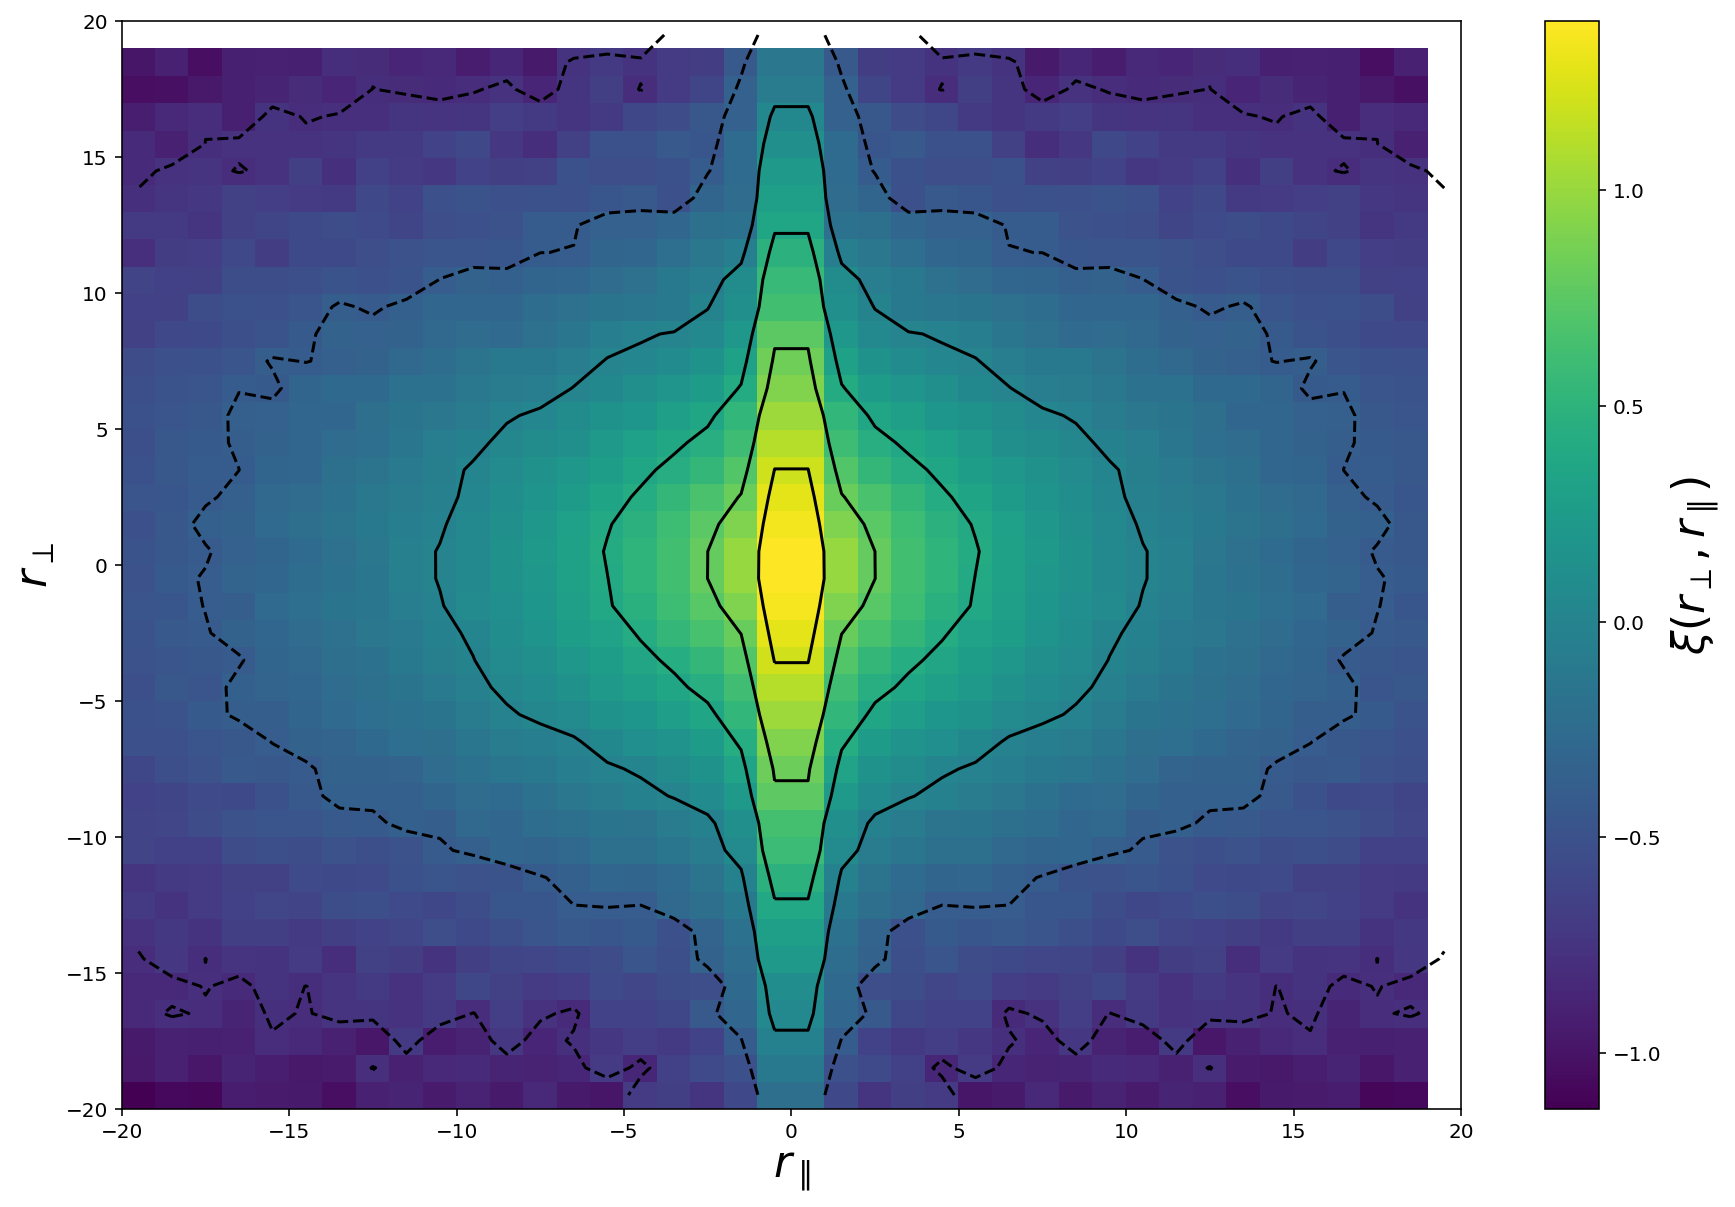

In [16]:
#solutione to work 1 part 2
drper=0.5*np.mean(xi_dic['rper'][1:]-xi_dic['rper'][:-1])
drpar=0.5*np.mean(xi_dic['rpar'][1:]-xi_dic['rpar'][:-1])

pl.figure(figsize=(15,10))
pl.pcolor(xi_dic['rper']-drper,xi_dic['rpar']-drpar,np.log10(xi_dic['xi2d']))

#add color bar
pl.colorbar().set_label(label=r'$\xi(r_\perp,r_\parallel)$',size=22,weight='bold')

#make the contour plot
pl.contour(xi_dic['rper'],xi_dic['rpar'],np.log10(xi_dic['xi2d']),colors='k')

pl.xlabel(r'$r_\parallel$',fontsize=22)
pl.ylabel(r'$r_\perp$',fontsize=22)
pl.xlim([-20,20])
pl.ylim([-20,20])

# <font size=5, color='blue'> Work 8 (10 minutes): Now compute monopole and quadruple moment of the correlation function and make plots from data. </font>

# Hint: you need to think about sampling axis and limits

In [17]:
#datafile='../data/GAMA-G15-galaxy.txt'
#randfile='../data/GAMA-G15-random.txt'
xi_dic=get_xi(datafile,randfile=randfile,rlim=[0,40,0,1],nbins=[20,60],sampmode=0,njn=0,pbc=0,los=0,rsd=0
                  ,filetype='polartxt')

../CorrelationFunction/Runme_Correlation.py -data ../data/LOWZ-all-galaxy.txt -rand ../data/LOWZ-all-random.txt -randfactor 2 -sampmode 0 -samplim 0.000000 40.000000 0.000000 1.000000 -nbins 20 60 -pbc 0 -los 0 -Lbox 250.000000 -outfile tmp/PairCount/tmp -RSD 0 -njn 0 -filetype polartxt -nproc 4
/Users/shock/Documents/talks/ICTS2019/lss-handson/CorrelationFunction/General_FITS_selection.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  tb=tb.as_matrix()
/Users/shock/Documents/talks/ICTS2019/lss-handson/CorrelationFunction/General_FITS_selection.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  tb=tb.as_matrix()
nrand selected:  635560 635560
    317780 galaxies from ../data/LOWZ-all-galaxy.txt
    635560 randoms from ../data/LOWZ-all-random.txt

Time:1 sec

Prepared data and random:1 sec

Workind on DD (. every 100k points):

Finished DD in 2 sec with 4 process and 317780 317780 particle

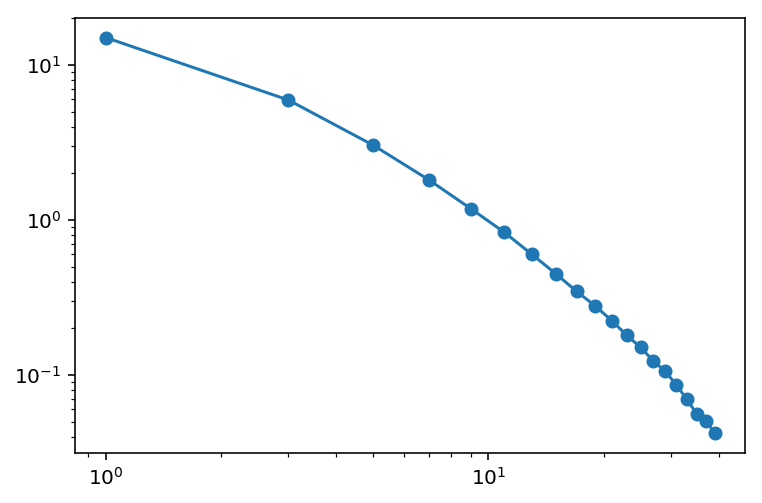

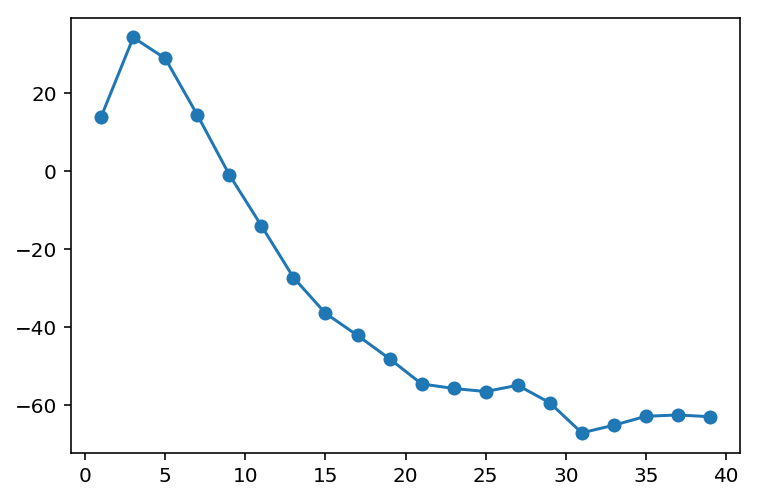

In [18]:
pl.plot(xi_dic['xi0'][:,0],np.power(xi_dic['xi0'][:,0],0)*xi_dic['xi0'][:,1],'o-')
pl.xscale('log')
pl.yscale('log')
    
pl.figure(2)
pl.plot(xi_dic['xi2'][:,0],np.power(xi_dic['xi2'][:,0],2)*xi_dic['xi2'][:,1],'o-')


# <font size=5, color='blue'> Work 9: Now compute the jackknife errors of the multipoles for data. </font>

# For the polar file which is how real data is you need to create files with five columns RA,DEC,Z,weight,jackknife number and then rerun the analysis

In [19]:
datafile='../data/LOWZ-all-galaxy.txt'
randfile='../data/LOWZ-all-random.txt'

rand=np.loadtxt(randfile)

Text(0.5, 1.0, 'SDSS LOWZ sample')

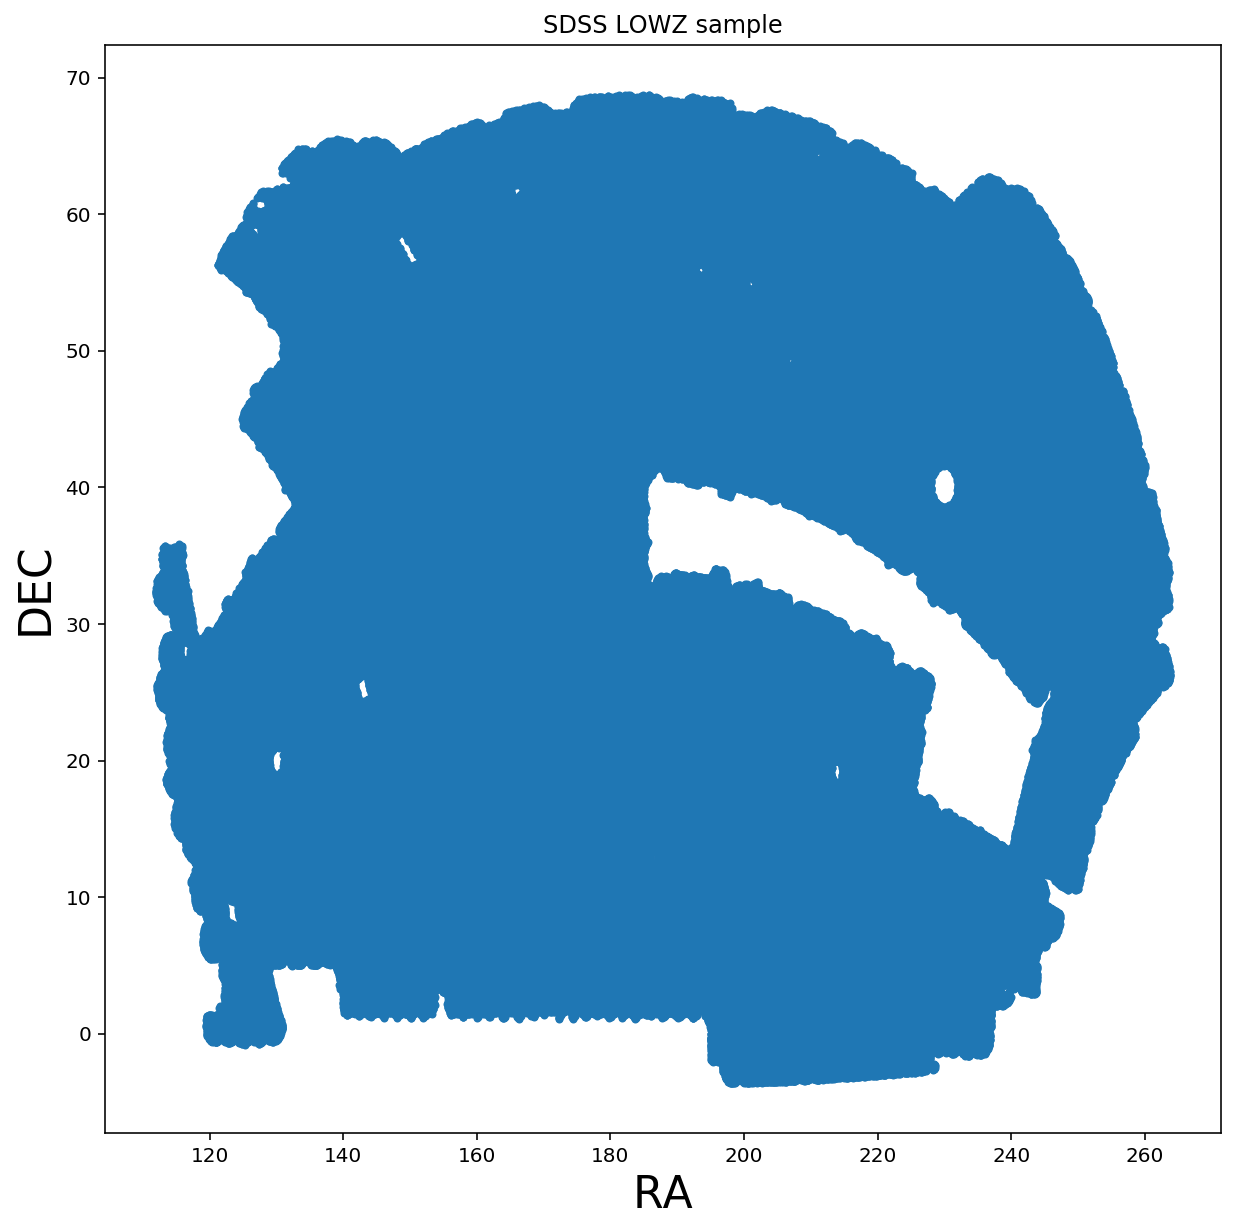

In [20]:
pl.figure(figsize=(10,10))
pl.plot(rand[:,0],rand[:,1],'.')
pl.xlabel('RA',fontsize=22)
pl.ylabel('DEC',fontsize=22)
pl.title('SDSS LOWZ sample')